### CNN architecture. Ex: EfficientNet_v2

- Algoritmes d'exploració d'arquitectures. 
- Defineixen l'espai de possibles arquitectures que hi ha. 
    - defineixen capes, blocs que es poden agrupar les capes.
    - quan hi ha una convolucio pot fer una sortida molt gran.
    - 64 filtres redueixen de 100 a 80 però ho hem multiplicat per 64.
    - si no ho controlem pot pujar, molt
    - hem d'aplicar el poling o de convolucio de kernel 1 (tecniques per tornar a comprimir la info)
- dins l'espai d'exploració, no podem deixar que l'algorisme explorit tot aleatoriament (defineixen blocs)
- les arquitectures són rares i venen d'altres models.

In [1]:
import torch

- Establir amb quin dispositiu estem treballant:
    - pot ser cuda si tenim gpu disponible.
- Aixi el script pot correr per les dues coses.

In [2]:
_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_device

device(type='cuda', index=0)

In [3]:
model = torch.load('../mosquits/cnn_mosquits/stage1/classifier.pth').to(_device)
type(model)

timm.models.efficientnet.EfficientNet

- importa el classificador .pth (model entrenat). 
- altre opció fitxer.pt, agafes els pesos
- has de carregar tim i posar-li els pesos. 

### architecture

- Escollim arquitectura
- Entrenem
- Genera fitxer
- Podem guardar només els pesos &rarr; li podem carregar els pesos a la arquitectura. 
- També podem grabar tot (arquitectura i pesos) &rarr; fem torch load i ja es la arquitectura entrenada. 
- ve del modul timm i es una efficient net

In [4]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
   

- es com un diccionari (s'hi assembla) &rarr; clau: valor (valor = capa (dels diferents tipus, normalització, classificació, convolucio) o pot ser un bloc a la vegada)
- nom()
- (conv_stem) capa de convolució, els dos numeros primers canals d'entrada (3 canals d'entrada rgb) i el 24, canals de sortida, numero de kernels que farem servir. kernel_size 3x3, el stright: 2x2, agafem els tres primers i després ens desplaçem dos al costat i avall també dos, bias, no en té. 
    - com sabem la dimensió / tamany de la imatge? En general les arquitectures són obertes, té un màxim i mínim, l'efficient net max 380x380 i minim 120x120. aquella gent ho va decidir, es variable perque en el proccès d'entrenament una estrategia, va bé començar a entrenar amb el mínim 120x120. si ho reduim potenciem un tipus de cosa de la imatge (eliminem difuminats, etc). Per tant la xarxa es centrarà en coses més importants perque quan comprimim eliminem soroll. Comprimir-la fa que s'eliminin coses més esporadiques o menys importants i resaltem contorns forts, formes ven definides ho estem realçant. La xarxa es fixa més facilment en el que hi ha. i en mica en mica, quan ja sap interpretar les imatges, començem a fer-les més grans, li ensenyem més detallets que havien desaparescut. ja havia vist lu important i comença a veure més detalls. Si entrenessim desde 0 sería la estrategia correcta. pero es sol agafar coses preentrenades. 
    - quin tamany han de tenir les imatges, entre el min i maxim el que es vulgui. 
    - Entrenar una xarxa desde 0, els pesos es posen aleatoris al principi (0,1), cada parametre és aleatori. Entrenar tots els parametres, es necessita molt d'entrenament i ja ho han fet previament (google, amazon, ...) les han entrenat amb imatges generiques (cotxes, gats). s'ha entrenat i té uns pesos a entendre una mica al món. Per això podem començar amb aquests pesos (perque no tenim tantes dades i ho volem fer ràpid). S'agafen aquestes xarxes i es fa un **find tuning**, ja la tens entrenada i li pases les teves imatges i s'acaba d'ajustar, també es diu **transfer learning**. Acabar-la d'ajustar perque solucioni el nostre problema concret. els dos negretes la diferencia es que find tuning es en general per models i transfer learning més relacionat amb les xarxes neuronals. una manera de parlar. 
    - La capa ens tornarà 24 canals.
- (bn1)
    - (drop) es el drop out que apaga neurones per no overfitting
    - (act) funció d'activació que es una SiLU
- (blocks) una altre fase -> extracció d'atributs.
- (conv_head)
- (bn2): normalització
- (global_pool)

#### input

In [5]:
model.conv_stem

Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)

#### feature extraction

- veure les formes que hi ha a les imatges.
- parla de reducció i expansió. 

In [6]:
model.feature_info

[{'stage': 1, 'reduction': 2, 'module': 'blocks.0', 'num_chs': 24},
 {'stage': 2, 'reduction': 4, 'module': 'blocks.1', 'num_chs': 48},
 {'stage': 3, 'reduction': 8, 'module': 'blocks.2', 'num_chs': 64},
 {'stage': 5, 'reduction': 16, 'module': 'blocks.4', 'num_chs': 160},
 {'stage': 6, 'reduction': 32, 'module': 'blocks.5', 'num_chs': 256}]

In [7]:
len(model.blocks)

6

In [8]:
i = 0
model.blocks[i]

Sequential(
  (0): ConvBnAct(
    (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (drop_path): Identity()
  )
  (1): ConvBnAct(
    (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (drop_path): Identity()
  )
)

- El bloc 0 esta compost de dos sublocs. 
    - que fan més o menys el mateix. 
    - composats per una capa de convolució (entrada 24 que han sortit de la capa previa) i sortida 24 més, padding es posar 1px al voltant de la imatge perque cuadri. com manega el padding ho hauríem de mirar a la docu (si es negre, igual que l'ultim).
    - la capa de BatchNormAct2d:
        - Es va descubrir que el resultat de la convolució, podría haber-hi diferencies motlt grans entre els valors de uns px i d'uns altres i el que anava molt bé es que si d'alguna manera es normalitzaven aquests valors, es feien servir els valors normalitzats per la següent capa, el rendiment era millor. Hi ha una funció d'activació, si l'activem amb valors molt alts, es satura i perdem la informació. Si normalitzem, entren dins el rang el qual la funció d'activació té una resposta més lineal. a vegades ens va bé respostes no-lineals, però està bé que no es saturi sempre. Aquesta normalització es fa per batch.
        - un batch es quan s'entrena una xarxa, l'entrenament s'organitza amb **epoch** que es quan la xnn ha vist totes les dades (un pas de totes les dades al model). de tot el dataset les imatges es pasen amb batches, lot de imatges, 10, 20, 120, 32. La normalització no s'ativa fins que no han passat tots els valors del batch, no normalitzem per totes les imatges sino ho fem pet tot el batch. Al cap de 10 imatges es farà la normalització. El tamany de batch depen de la memoria de gpu, + més imatges podem estar procesant a la vegada i més gran pot ser el batch size. El volem gran perque el backpropagation de l'error, es fa al final del batch, l'error es un error acomulat per totes les imatges. si li ensenyem 1 estem condicionant el update en aquella imatge, i en pasarem una altre i serà una cosa diferent, anirem propagant errors que no tenen res a veure, crearà una actualizació dels pesos en sentit contrari. Si el batch size es molt petit es molt dificil que la xarxa aprengui algo. si abans de propagar l'error li passem 25 o 200 imatges l'error es un error promig de moltes coses que ja ha vist diferents. quan nosaltres anem a actualizar els pesos, aqueta correció es correspon amb moltes diferents coses que han passt. Llavors amb el seguent batch és més probable que estigui alineat. 
        - Despres de la capa de convolució fem la normalització però en base al batch. 
        - Passarà per una capa de drop que es identity (que no hi ha drop en realitata).
            - Matriu de identity, hi ha 1 a la diagonal, totes les neurones s'activaran. 
        - Al final tenim la funció d'activació (SILU).
            - La silu és molt semblant a una ReLU, però baixa i fa una mica de sigmoide abans del 0, vol dir que per valors d'entrada negatius, sortida negativa, es 0 quan els valors són molt negatius (tenim una mica de control de negs). Han demostrat que la SiLU funciona millor que la ReLU. 

In [9]:
model.blocks[1]

Sequential(
  (0): EdgeResidual(
    (conv_exp): Conv2dSame(24, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (se): Identity()
    (conv_pwl): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNormAct2d(
      48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
    (drop_path): Identity()
  )
  (1): EdgeResidual(
    (conv_exp): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (se): Identity()
    (conv_pwl): Conv2d(192, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNormAct2d(
      48, eps=0.001, momentum

- (1): EdgeResidual.
    - fa una explosio de informació de 24 a 96
    - hi ha un kernel size de 1:1, tindriem lu mateix. 
        - la cuestio es que quan es parla de 1x1 no actua amb les dimensions de la imatges sino per la dimensió dels canals. 
- hem sortit de 0 amb 96 canals -> 96 imatges diferents que entren a la seguent amb el kernel de 1:1, fa un pooling més sofisticat, agafarà el px 1,2,.. i l'agafa per tots els canals i aquest kernel té 96 pesos compacta la informació del primer px ent tots els seus canals, combinació lineal de tots els valors del px per crear-ne un. Amb el pooling podem fer un promig, o un max pooling, min, en aquest fa un intermig, una combinació lineal. Si teniem 96, com acaba tinguent 48? perquè sobre tots els 96 dels px que estan a la posició 1x1, apliquem 48 kernels, k = [ w_1, ..] fins a 48 k i creem 48 convolucions o combinacions lineals. Aquesta capa en concret tindrà, 48kernels amb 96 pesos = 48x96 parametres que la xarxa ha d'apendre. I això torna a comprimir la informació, veniem de 24->96->48. 48 canal es una capa. 

- Tornem a lu de l'altre dia:
    - Tenim una imatge (cuadricula amb px -> 12px (3x4 cols), i suposem 1 canal
    - Tenim 12 neurones.
    - cada px es una neurona. 
    - llavors tenim un kernel 3x3 que no té 0 i 1 sinó que es una matriu de w
    - la primera vegada agafa els tres primers i la segona es va movent
    - agafa els que li toca i els porta en una neurona i cada un va multiplicat pel pes de la matriu. 
    - la sortida es la combinació lineal
    - vas posant neurones com tantes posibles vegades hem de pasar el kernel al img per els pixels que té
    - 1 kernel ha generat una sortida de dos neurones
    - tenim una imatge de 1x2, fer aquesta compresió
    - 
    - Si definim un altre kernel -> seran neurones en paralel a les dues que ja hi havia. 
    - La imatge que convertiem en 1x2, la convertim amb tantes com kernels haguem aplicat. 
    - 
    - Ara apliquem el kernel a totes aquestes imatges que han sortit (és el pooling), si l'apliquem només a un px, hem de tenir 4 pesos, perquè tenim 4 canals. multiplicarem cada w per el primer px, després movem, quan hem fet el kernel per tota la comvolució. surt al final una imatge de la mateixa midacom la del principi, converteix les tres imatges en una sola amb els pesos que indica els pesos del kernel de pooling. i per no perdre tanta informació, fem molts kernels. 
    - Els canals són com capes però amb 3d. 
    
- de 96 a 48, les colapsem de 48 maneres diferents.

- Pensem amb canals, una imatge amb color te tres canals, tres matrius tenen valors de 0-255, això definexi la imatge. 
- Com més kernels, més parametres.

- La naive fa una combinació és una xarxa fit forward. Ara parlem de capes però ja no ho son. Les neurones venen determinades perl numero de canals i el tamany del kernel. kernel de 3x3 sobre una imatge de 12 px capa de sortida de 2 neurones però dos canals. 
- ---
- 24, 96, canals d'entrada i sortida (pytorch fa aquesta abstració) amb numpy sería locura. pytorch genera les conexions.
- convolució en la dimensió espaia (alcada i amplada) amb un kernel x i després convolució amb kernel 1x1 que funciona per el colapse de tots els canals.
- Es la manera de controlar la dimensionalitat (anar obrinta canals i canals). 
- Expandim, comprimint, etc. 

#### sistema de codificar un sistema de equacions matematiques de moltes dimensions i per similitud acaba detectant. Però apendre no aprenen res.
- si tens una xarxa de test, accuracy de 95% i arriba una foto d'una llagosta i diu que es un albopictus.
- amb que es va fixar la xarxa per dir-ho, hi havia la llagosta tenia els ulls i va dir que per un ull hi havia el albopictus. 

- -- 
- block edge residual, convolució, expansio, comprimir, etc
- hi ha varis blocs48 - 192
- fer-ho d'aquesta manera és el resultat de la exploració de veure quins van millor. 
- ---
- s'explora amb algorismes genetics, hi ha varies arquitectures, i li donem posibilitats de mutar i les que entrenen i donen millor rendiment són les que tenen més capacitat de sobreviure. 

In [10]:
for name, module in model.blocks[0].named_modules():
    if hasattr(module, 'weight'):
        print('+++ %s' %name)
        print(module)
        print()

+++ 0.conv
Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

+++ 0.bn1
BatchNormAct2d(
  24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
  (drop): Identity()
  (act): SiLU(inplace=True)
)

+++ 1.conv
Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

+++ 1.bn1
BatchNormAct2d(
  24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
  (drop): Identity()
  (act): SiLU(inplace=True)
)



#### SiLU

<div>
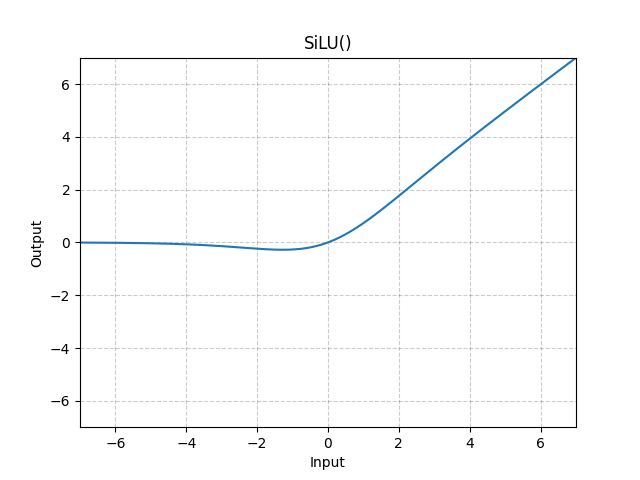
</div>

#### head
- es la capa final que converteix tot en un vector

In [11]:
model.conv_head

Conv2d(256, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)

#### classifier
- bias si per aquestes neurones hi ha bias o no


In [12]:
model.classifier

Linear(in_features=1280, out_features=7, bias=True)

In [13]:
model.num_features

1280

#### parameters
- Quants parametres en global implica una arquitectura com aquesta?
- Si tenim una capa de convolució de 24 canals i 96 sortida amb kernel size 3x4 -> c..2d(24, 96, Ks=(3,3))
- 24 canals posem de 24 maneres diferents la foto

In [14]:
sum(p.numel() for p in model.parameters())

20186455

- blocks es propi de la efficent net. 
- named_modules() es un metode de pytorch (de tots els models)

In [15]:
print('+++ model parameters:')
model_parameters = 0
for i, block in enumerate(model.blocks):
    block_parameters = 0
    for name, module in block.named_modules():
        # hasattr, de cualsevol classe, té aquest atribut, metode general de python. 
        # Metode útil en POO.
        if hasattr(module, 'weight'):
            if isinstance(module, torch.nn.Conv2d):
                block_parameters += torch.numel(module.weight.data)
            elif isinstance(module, torch.nn.BatchNorm2d):
                block_parameters += torch.numel(module.weight.data)
                block_parameters += torch.numel(module.bias.data)
    #print('+++ %s', model.feature_info[i])
    print('... block %d, %8d' %(i, block_parameters))
    model_parameters += block_parameters
print('... total  , %8d' %model_parameters)

+++ model parameters:
... block 0,    10464
... block 1,   303552
... block 2,   589184
... block 3,   914688
... block 4,  3455040
... block 5, 14538432
... total  , 19811360


- n'hi ha menys perque esta iterant només pels blocs, no conta la capa de input, convolution head, ni la classificació, aquests parametres són la diferencia dels que surten a dalt i els que surten aquí.

- chat gpt pot tenir 100B (anglesos) de parametres.
- molts recursos i molt energia.
- la humanitat ja no es capaç de generar la informació necessaria per entrenar-la.

In [16]:
block_parameters = 0
for name, module in model.named_modules():
    if hasattr(module, 'weight'):
        if isinstance(module, torch.nn.Conv2d):
            block_parameters += torch.numel(module.weight.data)
        elif isinstance(module, torch.nn.BatchNorm2d):
            block_parameters += torch.numel(module.weight.data)
            block_parameters += torch.numel(module.bias.data)
        elif isinstance(module, torch.nn.Linear):
            block_parameters += torch.numel(module.weight.data)
            block_parameters += torch.numel(module.bias.data)
print(block_parameters)

20151263


- Aquí ha fet un intent de calcular-lo amb més capes

#### Tot aixo es el proces d'extracció d'atributs, acaba amb un paquet de canals
- Alguns models incorpora el convolutional head (és la cua, el final)
- El head doan el vector final. en aquest cas de 1280 posicions (numeros pelats) que resumeixen la info que hem sigui capaços de extreure de la imatge. 
- Passa a la capa de classificació, tindrem tantes neurones com classes. conectem els 1280 a cada una de les neurones (fully conected layer). És la regressió lineal. 

--- 

#### Quan fem un import torch
- es un model de calcul tensorial
- numpy, calculs amb arrays, objecte basic es l'array i tenim tota la algebra de arrays implementada. 
- torch, en comptes de arrays, tenim tensors.
- un tersor es un array multidimensional amb més coses. 
- array que se li asocien gradients i altres coses
- torch es el modul que implementa la algebra tensorial, això ens permet implementar classes de capes per crear xarxes neuronals. 
- quan agafem una arquitectura anem a `tim, keras, tensorflwo` però no a torch
- son extraxions a més alt nivell
- ---
- si volem crear una xarxa neuronal customitzada (aquesta capa, etc)
- només ho podem fer amb torch. 
- amb keras i així es molt més facil però hi ha les arquitectures que hi ha. 
- torch, només te sentit per disenyar una xarxa neuronal per un problema molt concret.
- arquitectures existents yolo.
- lligues el torch amb el timm per fer aquitectures custom (tim te les arquitectures)
- tim carregues la arquitectura, torch la entrenes i la guardes i fas un torch load per fer-la servir. 

In [17]:
model.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s_21ft1k-d7dafa41.pth',
 'hf_hub_id': 'timm/tf_efficientnetv2_s.in21k_ft_in1k',
 'architecture': 'tf_efficientnetv2_s',
 'tag': 'in21k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 300, 300),
 'test_input_size': (3, 384, 384),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': (10, 10),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

- informació de com es va entrenar la xarxa neuronal.
- fix input size: xarxa de mida variable.
- parametres de pre entrenamament
    - quan fem timm create module i carreguem els pesos de la xarxa com es va pre entrenar. 
    - la van entrenar a 300
    - i testejar a 344
    - es va entrenar amb coco set 1M imatges
- com que després li farem un find tinning (entrenar per sobre) amb les nostres dades per acabar de afinar. 
- l'acabem d'ajustar amb imatges específiques del nostre problema. 
- aquest segon entrenament, el podem fer a una altre mida, sempre que estigui dins del maxim.
- si nosaltres entrenem amb una determinada mida. en aquest cas lu recomenable és fer la inferència amb aquesta mida. 
- Quina diferencia hi ha fer-ho a una mida o una altre?
    - mida més gran, més resolució, més informació, extracció d'atributs més fina. 
    - necesites més memòria, més temps. trade off
- segurament més enllà del limit de memòria, el que hauríem de fer es vàries proves a diferentes mides. 
    - batch size x i mida (ho permet la memòria)
    - redueixo batch size i augmento mida de les imatges 
    - mateixos requeriments de memòria i més info a les fotos. 